In [1]:
import os
import numpy as np
import pandas as pd
import spacy
from spacy import displacy
import itertools as it
import re
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bhanu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhanu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [2]:
fields = ['content']
reviews_df = pd.read_csv('reviews.csv', usecols=fields)

In [3]:
reviews_list = reviews_df.content.values.tolist()

In [4]:
reviews_list[12]

'It was very close to the rear exit with engine view.\r\nJust fine for me.'

In [5]:
# Remove Emails
reviews_list = [re.sub(r'\S*@\S*\s?', '', sent) for sent in reviews_list]
reviews_list = [re.sub(r'\s+', ' ', sent) for sent in reviews_list]
reviews_list = [re.sub(r"\'", "", sent) for sent in reviews_list]

In [6]:
len(reviews_list)

117550

In [7]:
reviews_list[0]

'From Istabul to Athens. Seat 3C doesnt have any extra legroom.'

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(reviews_list))

In [9]:
pprint(data_words[:2])

[['from',
  'istabul',
  'to',
  'athens',
  'seat',
  'doesnt',
  'have',
  'any',
  'extra',
  'legroom'],
 ['traveled',
  'athens',
  'zurich',
  'with',
  'aegean',
  'airlines',
  'and',
  'the',
  'sx',
  'dnb',
  'aircraft',
  'chose',
  'the',
  'position',
  'this',
  'place',
  'is',
  'awkward',
  'the',
  'foot',
  'space',
  'is',
  'minimal',
  'and',
  'the',
  'window',
  'is',
  'in',
  'an',
  'uncomfortable',
  'position',
  'the',
  'display',
  'is',
  'two',
  'rows',
  'ahead']]


In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[12]]])

['it', 'was', 'very', 'close', 'to', 'the', 'rear', 'exit', 'with', 'engine', 'view', 'just', 'fine', 'for', 'me']


In [11]:
stop_words = stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):#, 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])#, 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['athen', 'seat', 'legroom']]


In [13]:
data_lemmatized[12]

['exit', 'engine', 'view']

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=20, no_above=0.4)
id2word.compactify()

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [15]:
id2word[17]

'cabin'

In [16]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('athen', 1), ('legroom', 1)]]

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=75,
                                           alpha='auto',
                                           per_word_topics=True)

In [18]:
pprint(lda_model.print_topics())
#doc_lda = lda_model[corpus]

[(0,
  '0.076*"time" + 0.069*"hour" + 0.046*"plane" + 0.037*"customer" + '
  '0.036*"bag" + 0.035*"luggage" + 0.031*"check" + 0.025*"minute" + '
  '0.017*"trip" + 0.016*"leg"'),
 (1,
  '0.091*"airline" + 0.064*"service" + 0.048*"airport" + 0.043*"staff" + '
  '0.041*"air" + 0.035*"food" + 0.033*"crew" + 0.028*"cabin" + '
  '0.025*"experience" + 0.016*"aircraft"'),
 (2,
  '0.094*"passenger" + 0.084*"boarding" + 0.062*"people" + 0.062*"gate" + '
  '0.051*"delay" + 0.049*"board" + 0.022*"reason" + 0.022*"home" + 0.022*"bus" '
  '+ 0.020*"family"'),
 (3,
  '0.054*"entertainment" + 0.043*"hotel" + 0.036*"london" + 0.033*"pm" + '
  '0.028*"ground" + 0.028*"system" + 0.023*"choice" + 0.022*"arrival" + '
  '0.022*"morning" + 0.021*"snack"'),
 (4,
  '0.052*"day" + 0.045*"ticket" + 0.042*"review" + 0.033*"way" + '
  '0.026*"baggage" + 0.025*"cost" + 0.025*"money" + 0.020*"pay" + '
  '0.018*"company" + 0.017*"issue"')]


In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.716656450152103

Coherence Score:  0.5135675515842056


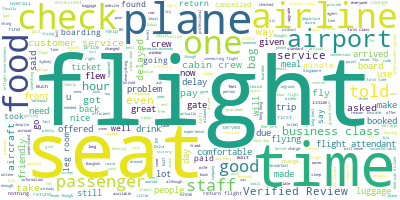

In [20]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(reviews_df['content'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

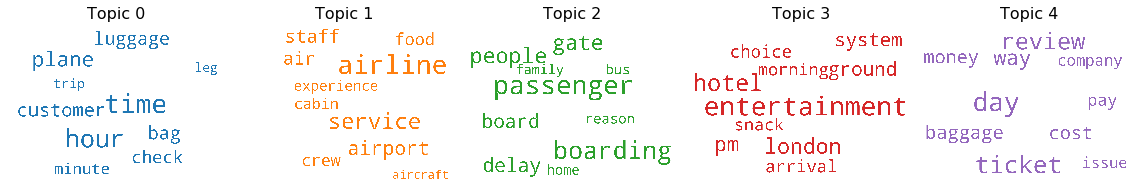

In [21]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(16,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

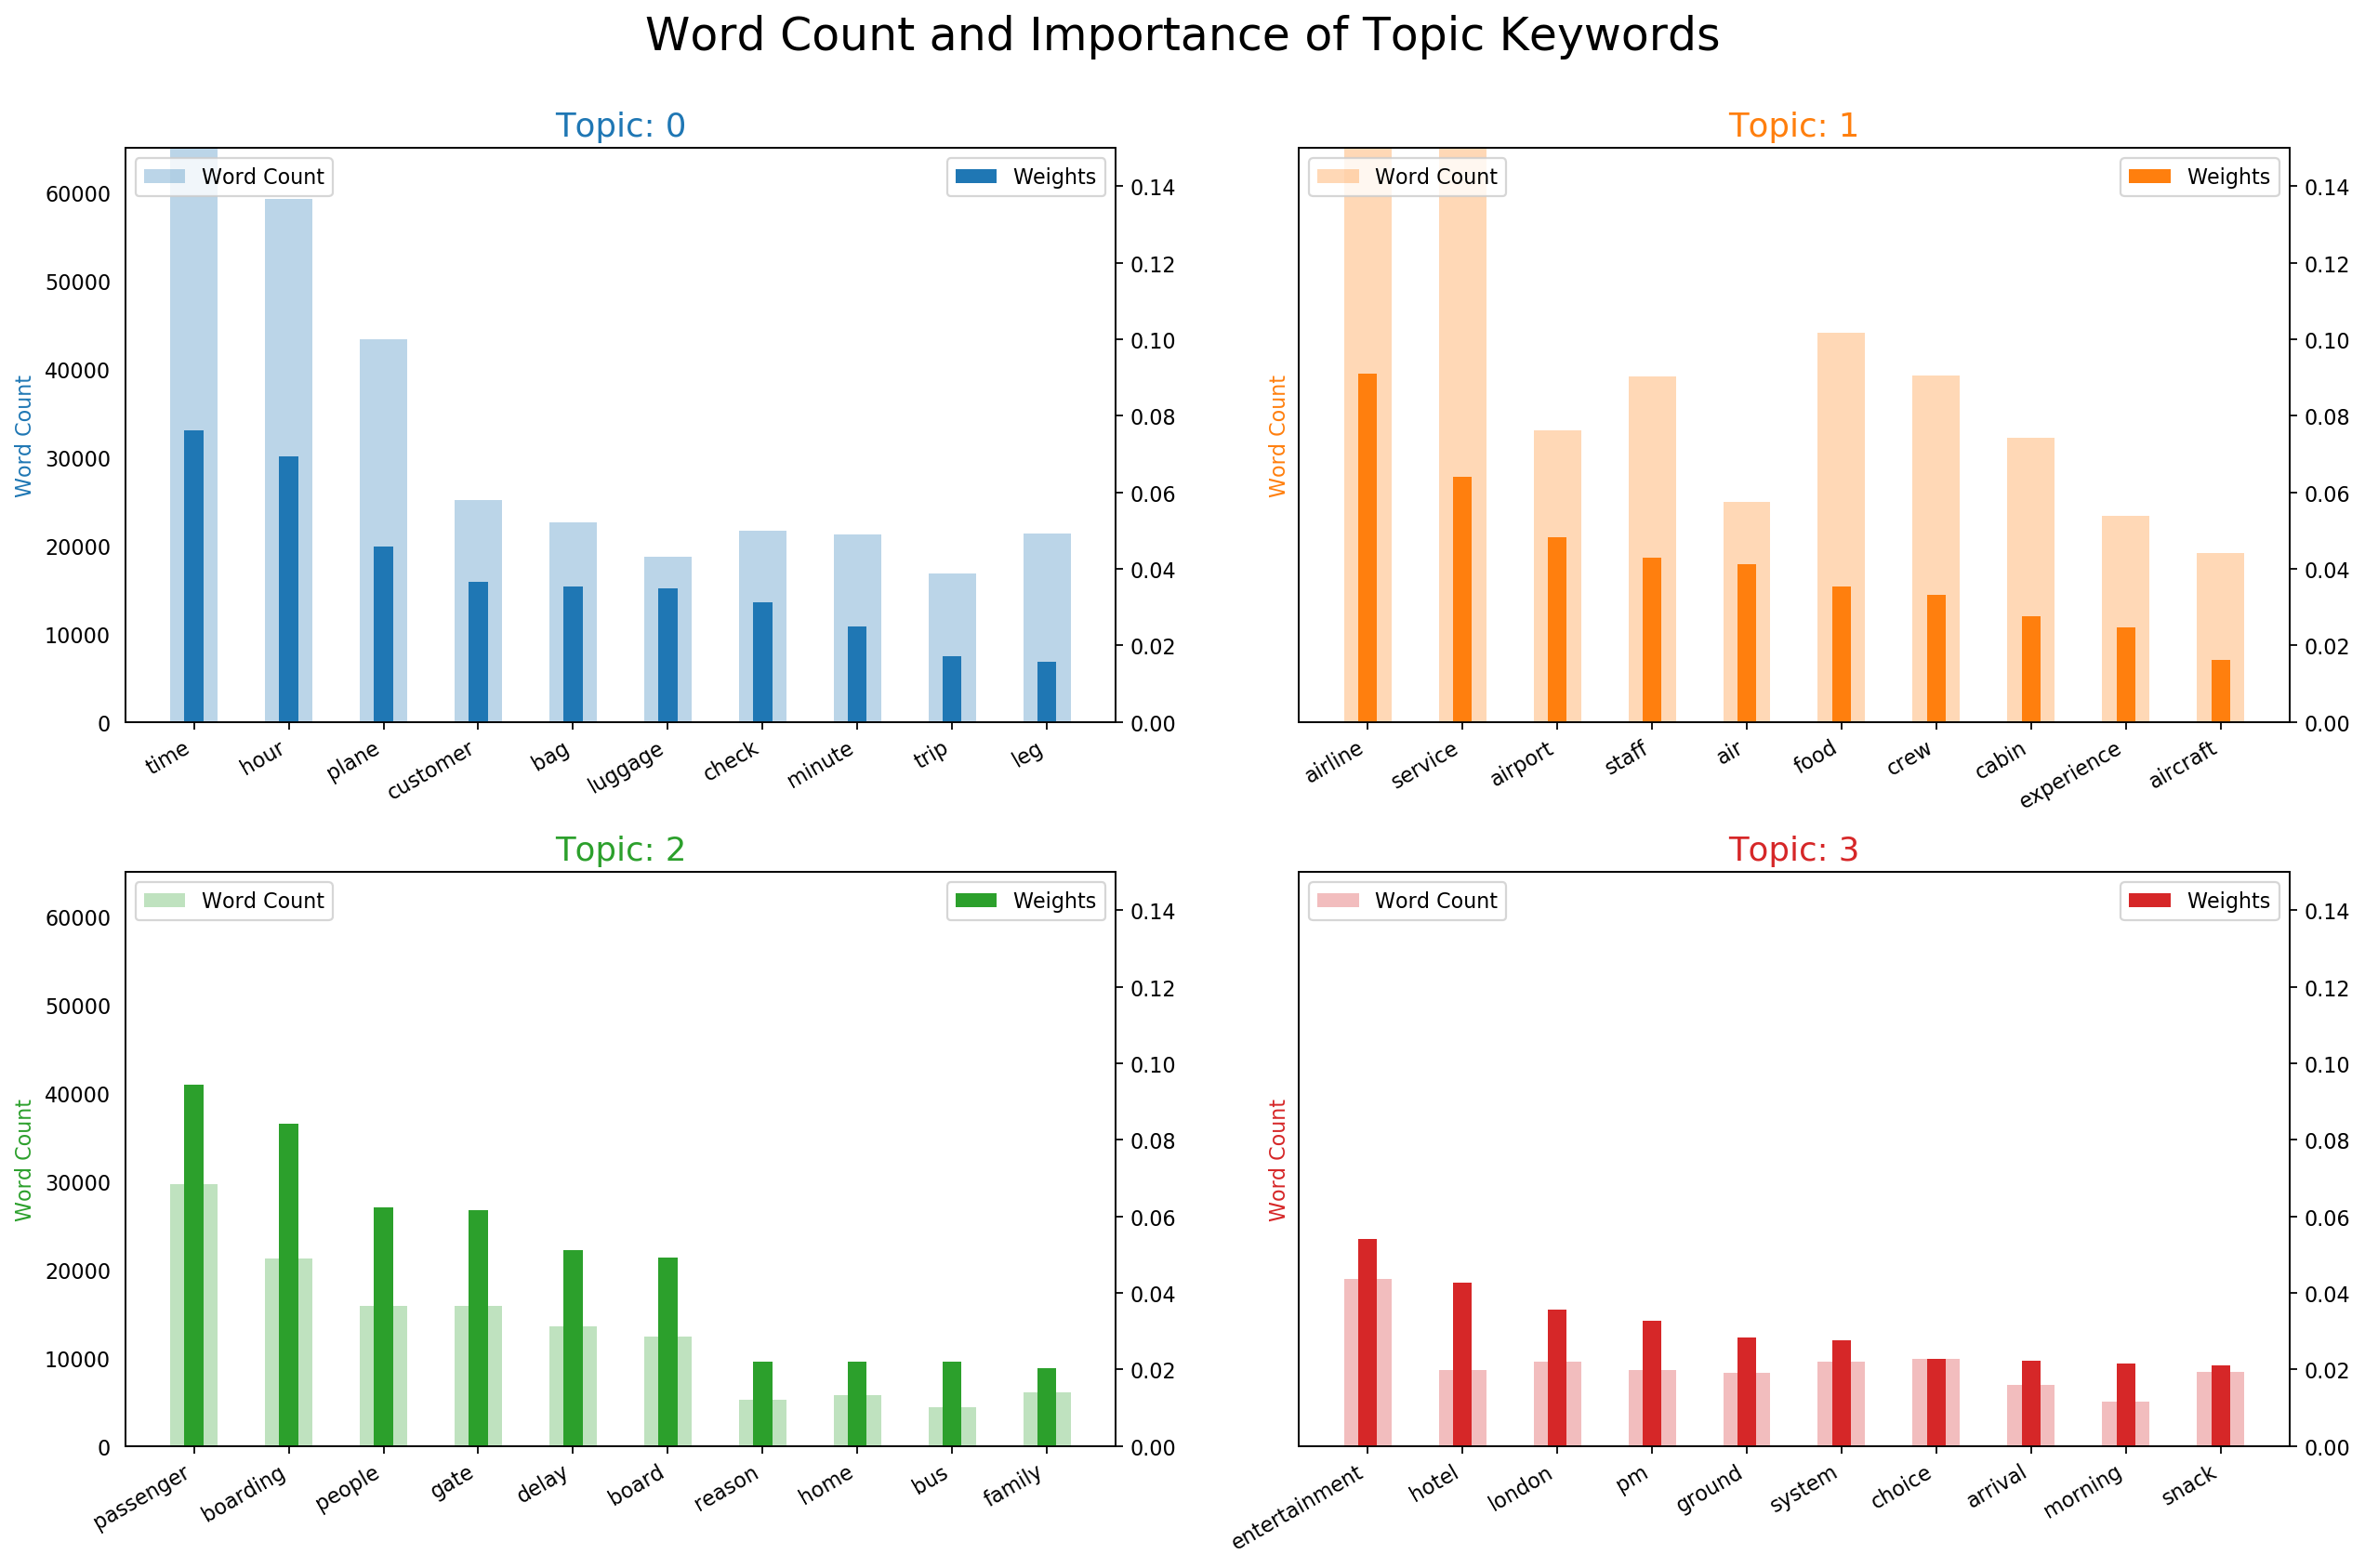

In [22]:
# Word counts of topic keywords
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.150); ax.set_ylim(0, 65000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [23]:
## To know most discussed topics in the documents

# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 10]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

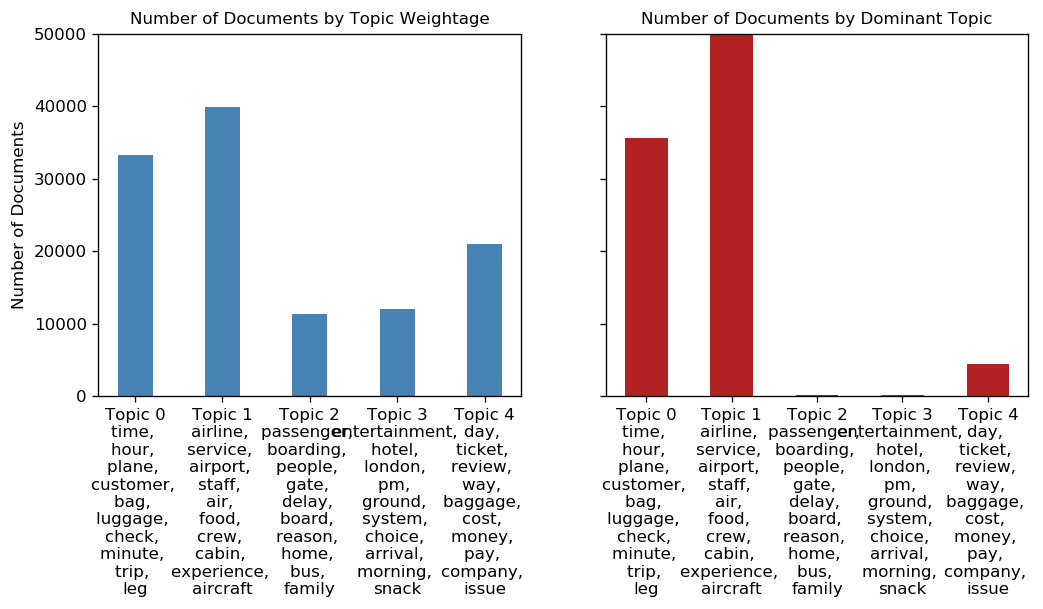

In [24]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)
# fig, ax2 = plt.subplots(1, 1, figsize=(10, 4), dpi=120, sharey=True)
# fig, ax1 = plt.subplots(1, 1, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.4, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
ax2.set_ylabel('Number of Documents')
ax2.set_ylim(0, 50000)


# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
#ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 50000)

plt.show()

In [25]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 66864 samples in 0.050s...
[t-SNE] Computed neighbors for 66864 samples in 4.727s...
[t-SNE] Computed conditional probabilities for sample 1000 / 66864
[t-SNE] Computed conditional probabilities for sample 2000 / 66864
[t-SNE] Computed conditional probabilities for sample 3000 / 66864
[t-SNE] Computed conditional probabilities for sample 4000 / 66864
[t-SNE] Computed conditional probabilities for sample 5000 / 66864
[t-SNE] Computed conditional probabilities for sample 6000 / 66864
[t-SNE] Computed conditional probabilities for sample 7000 / 66864
[t-SNE] Computed conditional probabilities for sample 8000 / 66864
[t-SNE] Computed conditional probabilities for sample 9000 / 66864
[t-SNE] Computed conditional probabilities for sample 10000 / 66864
[t-SNE] Computed conditional probabilities for sample 11000 / 66864
[t-SNE] Computed conditional probabilities for sample 12000 / 66864
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [119]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.263310 -0.004447       1        1  40.722599
3     -0.277456 -0.027652       2        1  25.599586
1      0.206132 -0.380281       3        1  15.079692
2      0.173592  0.249782       4        1  10.956197
0      0.161042  0.162597       5        1   7.641921, topic_info=     Category          Freq       Term         Total  loglift  logprob
265   Default  42215.000000    airport  42215.000000   30.000  30.0000
35    Default  30009.000000  passenger  30009.000000   29.000  29.0000
1     Default  75304.000000    airline  75304.000000   28.000  28.0000
19    Default  60779.000000    service  60779.000000   27.000  27.0000
175   Default  32410.000000        bag  32410.000000   26.000  26.0000
...       ...           ...        ...           ...      ...      ...
602    Topic5   1454.670044     boeing   1455.413086    2.571  -5.0238
156    Topic5   1449.816772        guy   1450.566895    2.571  -5.0271
1429   Topic5   1461.851440    payment   1462.609741    2.571  -5.0188
901    Topic5   1384.594360     status   1385.341797    2.571  -5.0731
2329   Topic5   1387.870117  personnel   1388.621094    2.571  -5.0708

[188 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
163       5  0.999361    access
1212      4  0.999888     agent
284       1  0.999969       air
0         2  0.999956  aircraft
1         1  0.999992   airline
...     ...       ...       ...
4565      2  0.016625    xiamen
4565      3  0.010792    xiamen
4565      4  0.948523    xiamen
4565      5  0.014584    xiamen
88        1  0.999868      year

[166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 3, 1])